<a href="https://colab.research.google.com/github/shekhar-hazari/CML-Assignment-2/blob/main/Luke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
In this task a cancer cell detection system will be created.

Luke Mason - s3630120 \
Shekhar Hazari - s3831855

# 0 - Setup

## 0.1 - Import packages

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 0.2 - Initialise helper functions¶

In [2]:
def holdout_validation(train_size, X, Y):
    
    # Get the difference between train and test size, together both make 100% of the raw data set.
    test_size = 1 - train_size
    
    # Split into train and test for normal and target fields set, left overs are for validation and test.
    with pd.option_context('mode.chained_assignment', None):
        train_X, X_test_, train_Y, Y_test_ = train_test_split(X, Y, test_size=test_size, shuffle=True,random_state=0)

    # Split the test data into validation test and test.
    # Do for target field and normal fields.
    with pd.option_context('mode.chained_assignment', None):
         val_X, test_X, val_Y, test_Y = train_test_split(X_test_, Y_test_, test_size=0.5, shuffle=True, random_state=29)
    return train_X, val_X, test_X, train_Y, val_Y, test_Y

In [3]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows,ncols,index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
        
    plt.title(title)
    plt.xticks(rotation='vertical')

In [4]:
def train_val_test_split_by_column(dataframe, column, train_size = 0.666, val_size = 0.5):
  splitting_IDs = dataframe[column].unique()
  train_IDs, test_IDs = train_test_split(splitting_IDs, train_size = train_size)
  val_IDs, test_IDs = train_test_split(test_IDs, train_size = val_size)

  train_IDs = pd.DataFrame(train_IDs)
  train_IDs.rename(columns = {0:column}, inplace = True)
  train_IDs['split'] = 'train'

  val_IDs = pd.DataFrame(val_IDs)
  val_IDs.rename(columns = {0:column}, inplace = True)
  val_IDs['split'] = 'validation'

  test_IDs = pd.DataFrame(test_IDs)
  test_IDs.rename(columns = {0:column}, inplace = True)
  test_IDs['split'] = 'test'

  splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

  dataframe = pd.merge(dataframe, splits, on = column)

  train_set = dataframe[dataframe['split'] == 'train']
  train_set = train_set.drop(['split'], axis = 1)

  validation_set = dataframe[dataframe['split'] == 'validation']
  validation_set = validation_set.drop(['split'], axis = 1)

  test_set = dataframe[dataframe['split'] == 'test']
  test_set = test_set.drop(['split'], axis = 1)

  return train_set, validation_set, test_set

In [5]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, 
                        metric_name='Accuracy', test_loss="", test_metric=""):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    if test_loss != "":
      plt.plot(test_loss, 'g--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    if test_metric != "":
      plt.plot(test_metric, 'g--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [6]:
def get_imagery_data_sets(train_set, validation_set, test_set, directory, 
                          x_col, y_col, batch_size):
  
  # Make target feature a string so that the categorical class_mode can categorise it.
  train_set[y_col] = train_set[y_col].astype('str')
  validation_set[y_col] = validation_set[y_col].astype('str')
  test_set[y_col] = test_set[y_col].astype('str')

  train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
  val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
  test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
  
  # The parameters that all data set generators have in common.
  generator_parameters = dict(
      directory=directory,
      x_col="ImageName",
      y_col="isCancerous",
      target_size=(27, 27),
      class_mode='categorical')
  
  # Train set generator to evaluate produce dataframe with train images.
  train_imagery_set = train_datagen.flow_from_dataframe(
          dataframe=train_set,
          batch_size=batch_size,
          **generator_parameters)

  # Validation set generator to evaluate produce dataframe with validation images.
  val_imagery_set = val_datagen.flow_from_dataframe(
          dataframe=validation_set,
          batch_size=batch_size,
          **generator_parameters)

  # Test set generator to evaluate produce dataframe with test images.
  test_imagery_set = test_datagen.flow_from_dataframe(
          dataframe=test_set,
          batch_size=1,
          **generator_parameters)
  
  return train_imagery_set, val_imagery_set, test_imagery_set

## 0.3 - Unzip zipped data

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# Change according to your directory structure
!cp /content/drive/'My Drive'/CML-Assignment-2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


## 0.4 - Load the data
This data contains both the cell type and isCancerous labels.

In [9]:
main_data = pd.read_csv('./data_labels_mainData.csv', delimiter=',')
extra_data = pd.read_csv('./data_labels_extraData.csv', delimiter=',')

# 1 - Exploratory Data Analysis
The data is assumed to be made of entirely by newborn babies according to the assignment forums.\

## 1.1 - Main Data Set

### 1.1.1 - Splitting the data
Splitting the main dataset into train, validation and test sets

In [10]:
main_train_set, main_validation_set, main_test_set = train_val_test_split_by_column(main_data, 'patientID')

In [11]:
print('Overall ferquency of isCancerous:')
print(main_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(main_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(main_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(main_test_set.isCancerous.value_counts().to_frame())

Overall ferquency of isCancerous:
   isCancerous
0         5817
1         4079
Frequency of isCancerous in training data: 
   isCancerous
0         3994
1         2469
Frequency of isCancerous in validation data: 
   isCancerous
1          895
0          784
Frequency of isCancerous in test data: 
   isCancerous
0         1039
1          715


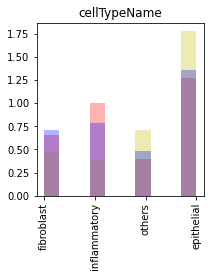

In [12]:
# Graph the results
plt.figure(figsize=(3,3))
col = "cellTypeName"
hist_plot(col, [main_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - Epithelial cell type is evenly distributed over the train, validation and test set, but the other types are not.

👨🏻‍🎓 **Conclusions**
> - 

### 1.1.2 - Preview
Previewing the contents of the main data set.

In [13]:
main_data.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [14]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [15]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [16]:
df1 = main_data.groupby(['cellTypeName', 'cellType'])['InstanceID'].nunique()
df2 = main_data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df1)
print(df2)

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: InstanceID, dtype: int64
isCancerous
0    5817
1    4079
Name: InstanceID, dtype: int64


🧐 **Observations:**
> - The different columns have different data typees and is not uniform
> - ImageName contains the image file name the results reference
> - isCancerous is the main target column
> - cellType is likely the secondary target column, and derived from isCancerous, and not the vice versa.
> - cellType is the encoded version of cellTypeName

👨🏻‍🎓 **Conclusions**
> - Make the data types over the dataset uniform, either into type string or object.
> - Use cellType instead of the cellTypeName
> - 

Preview the image data via cell type

In [17]:
label_names = {k: v for k, v in df1.keys()}
cellTypes = {v: k for k, v in label_names.items()}
print(label_names)
print(cellTypes)

{'epithelial': 2, 'fibroblast': 0, 'inflammatory': 1, 'others': 3}
{2: 'epithelial', 0: 'fibroblast', 1: 'inflammatory', 3: 'others'}


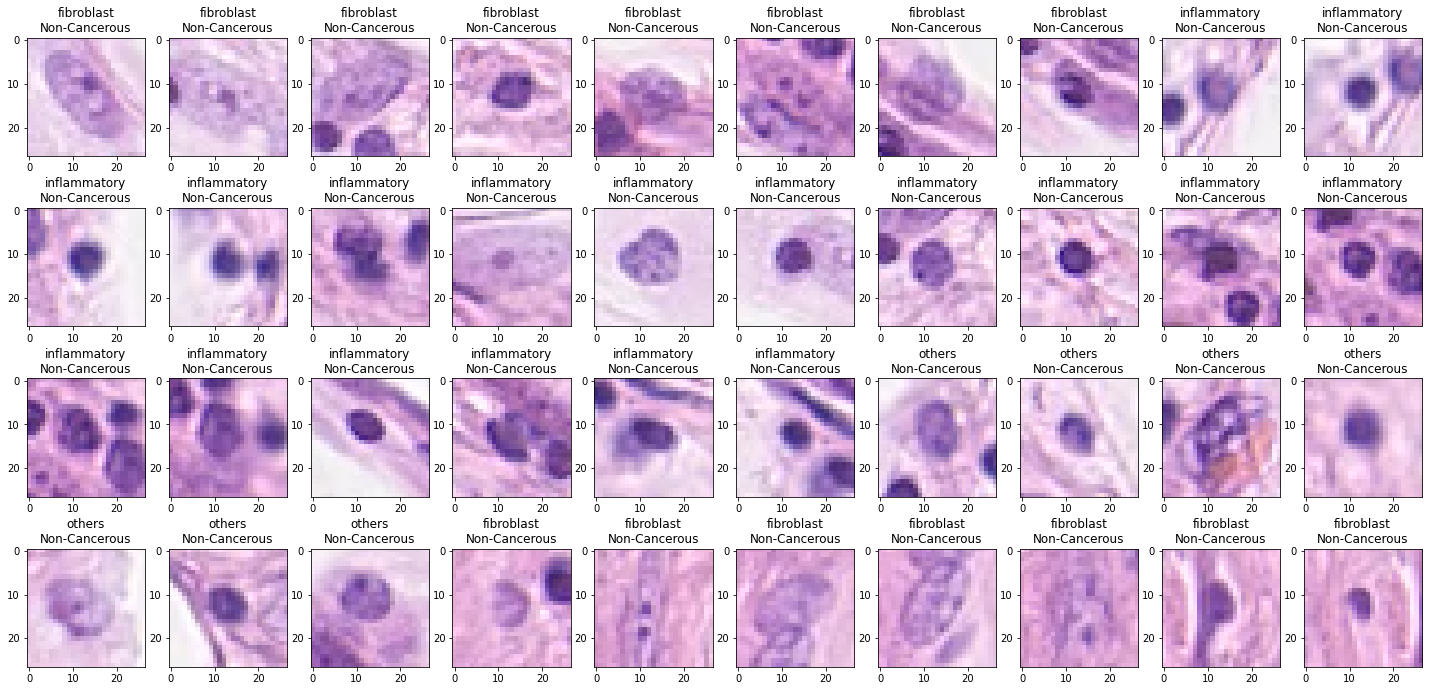

In [18]:
img_list = list(main_train_set["ImageName"])
types = list(main_train_set["cellType"])
target_list = list(main_train_set["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25,12])

for i in np.arange(40):
  plt.subplot(4, 10, i + 1)
  img = Image.open('./patch_images/' + img_list[i])

  plt.imshow(img)
  plt.title(cellTypes[types[i]] + "\n" + target_labels[target_list[i]])

In [19]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

### 1.1.3 - Transformation
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [20]:
for column in main_data.columns:
  main_data[column] = main_data[column].astype('object')

In [21]:
print(main_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   object
 1   patientID     9896 non-null   object
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   object
 5   isCancerous   9896 non-null   object
dtypes: object(6)
memory usage: 464.0+ KB
None


In [22]:
main_data.describe(include=['object'])

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
count,9896,9896,9896,9896,9896,9896
unique,9896,60,9896,4,4,2
top,972,54,17178.png,epithelial,2,0
freq,1,389,1,4079,4079,5817


🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

### 1.1.4 - Examination
Examining the data's distribution via bucketing the categories.



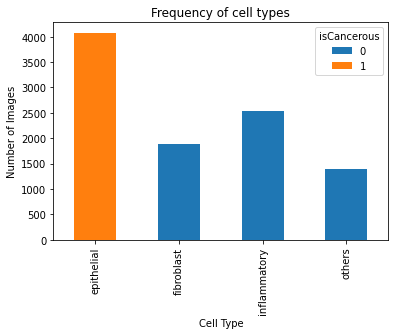

In [23]:
pd.crosstab(main_data['cellTypeName'], main_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Frequency of cell types',
                                                                                            xlabel = 'Cell Type',
                                                                                            ylabel = 'Number of Images')

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

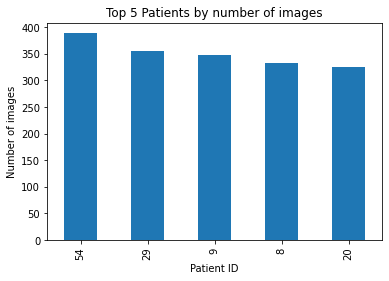

In [24]:
main_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

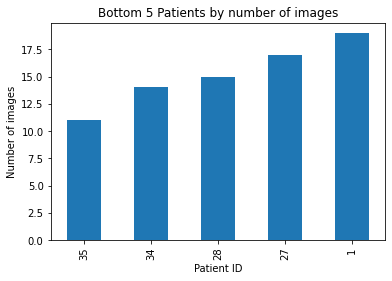

In [25]:
main_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

# 2 - Feature Selection

# 3 - Modelling 

In [26]:
# Initialise Constants
INPUT_DIM = (27,27,3)
OUTPUT_CLASSES = 2

## 3.1 - MLP

### 3.1.1 Cancerous Classification
Checking if the image is cancerous or not cancerous

#### Model 1

Hidden layer dimension is randomly set to a value that is 2^n to align with the computer's memory buffer. This is a starting point to iterate on.\
`hidden_layer_dim = 56`

TODO \
`optimizer = adam`

TODO \
`loss = CategoricalCrossentropy`

TODO \
`metrics = ['categorical_accuracy']`

TODO \
`epochs = 50`

TODO \
`batch_size = 32`

This model shows starts off with the input layer being the imagery with 3 colour bands, red, green, and blue.\
Then the images are flattened into a 1 dimensional array, [R,G,B] and passed into a single dense layer layer which ..........

In [60]:
def mlp(train_set, val_set, test_set, hyper_parameters, model, unique_id):
  
  # Extract the imagery into new data sets from the original data sets that 
  # contained the image references.
  train_imagery_set, val_imagery_set, test_imagery_set = get_imagery_data_sets(
      train_set, val_set, test_set, 
      './patch_images/', 'ImageName', 'isCancerous', hyper_parameters["batch_size"])

  # Compile the model with the hyper parameters chosen.
  model.compile(optimizer=hyper_parameters["optimizer"],
                loss=hyper_parameters["loss"],
                metrics=hyper_parameters["metrics"])
  
  # Print summary.
  model.summary()

  # Make the checkpoint name unique and happen once every 5 epochs
  full_checkpoint_path = unique_id + "/cp-{epoch:04d}.ckpt"
  
  # Create checkpoint file.
  checkpoint_dir = os.path.dirname(full_checkpoint_path)

  # Load model from checkpoint path
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  # loaded_model = tf.keras.models.load_model(checkpoint_dir)
  # print(loaded_model)
  # saver = tf.train.Saver()
  # saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir)))
  # graph = tf.get_default_graph()


  # if (latest != None):
  #   # Load the previously saved weights
  #   model.load(latest)
  #   loaded_model = tf.keras.models.load_model(checkpoint_dir)
  #   # Read in the history chart from fitting the model previously.
  #   print()

  #   # # Re-evaluate the model
  #   # loss, acc = model.evaluate(test_imagery_set, verbose=2)
  #   # print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

  # # Create a callback that saves the model's weights
  # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=full_checkpoint_path,
  #                                                save_weights_only=True,
  #                                                verbose=1,
  #                                                save_freq=5*hyper_parameters["batch_size"])

  # # Save the weights using the `checkpoint_path` format
  # model.save_weights(full_checkpoint_path.format(epoch=0))

  # # Fit the model with the generators, and epoch amount.
  # history = model.fit(train_imagery_set, validation_data = val_imagery_set, 
  #                     epochs=hyper_parameters["epochs"], verbose=0,
  #                     callbacks=[cp_callback]) 

  # # Plot the results for run though of the data (epoch).
  # plot_learning_curve(history.history['loss'], 
  #                     history.history['val_loss'], 
  #                     history.history['categorical_accuracy'], 
  #                     history.history['val_categorical_accuracy'], 
  #                     metric_name='Accuracy')

  # # Get test set accuracy result.
  # # print(model.evaluate(test_imagery_set))
  # # Re-evaluate the model
  #   loss, acc = model.evaluate(test_imagery_set, verbose=2)
  #   print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [58]:
def get_unique_id_from_hyperparameters(hyperparameters):
  return "h_" + str(hyperparameters["hidden_layer_dim"]) +\
   "_o_" + str(hyperparameters["optimizer"]) +\
   "_m_" + '-'.join(hyperparameters["metrics"]) +\
   "_e_" + str(hyperparameters["epochs"]) +\
   "_b_" + str(hyperparameters["batch_size"])

In [62]:
# Initial_hyper_parameters.
parameters = {
  "hidden_layer_dim": 56,
  "optimizer": 'adam',
  "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  "metrics": ['categorical_accuracy'],
  "epochs": 5,
  "batch_size": 32
}

# The Deep Neural Network Layer Structure.
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(parameters["hidden_layer_dim"], activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

# Train MLP.
id = get_unique_id_from_hyperparameters(parameters)
mlp(main_train_set, main_validation_set, main_test_set, parameters, model_1, str(id))

# Save model 1
model_1.save("model_1")
!cp -R ./model_1 /content/drive/'My Drive'/CML-Assignment-2/models/

Found 6463 validated image filenames belonging to 2 classes.
Found 1679 validated image filenames belonging to 2 classes.
Found 1754 validated image filenames belonging to 2 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 56)                122528    
_________________________________________________________________
dropout_11 (Dropout)         (None, 56)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 114       
Total params: 122,642
Trainable params: 122,642
Non-trainable params: 0
_________________________________________________________________


OSError: ignored

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [59]:
print(get_unique_id_from_hyperparameters(parameters))

h_56_o_adam_m_categorical_accuracy_e_5_b_32


Deep Learning HOG CV - Shekhar

CNN

In [ ]:
# CNN
# model_VGG_3 = tf.keras.Sequential([
#     #VGG block 1
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 2
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
#                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
#     tf.keras.layers.Dense(OUTPUT_CLASSES),
# ])

# Save model
# model_VGG_3.save("model_VGG_3")

Investigate Other Techniques hopefully OP

Explore how the data in both tasks can be used to improve the cell-type classification

# 4 - Ultimate Judgment

# 5 - Improving Ultimate Judgment with Extra Data Set

## Extra Data Set EDA

### 1.2.1 - Splitting the data

In [ ]:
extra_train_set, extra_validation_set, extra_test_set = train_val_test_split_by_column(extra_data, 'patientID')

In [ ]:
print('Overall ferquency of isCancerous:')
print(extra_data.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in training data: ')
print(extra_train_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in validation data: ')
print(extra_validation_set.isCancerous.value_counts().to_frame())

print('Frequency of isCancerous in test data: ')
print(extra_test_set.isCancerous.value_counts().to_frame())

In [ ]:
# Graph the results
plt.figure(figsize=(3,3))
col = "isCancerous"
hist_plot(col, [extra_train_set[col], main_validation_set[col], main_test_set[col]], ['r', 'y', 'b'], 1, 1, 1)

🧐 **Observations:**
> - There is very little cancerous cells in the train set, but a lot of non cancerous cells in the train set.
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [ ]:
extra_data.describe()

In [ ]:
extra_data.head()

In [ ]:
extra_data.info()

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

### 1.2.2 - Preview
Previewing the contents of the main data set.

In [ ]:
extra_data.describe()

In [ ]:
extra_data.head()

In [ ]:
extra_data.info()

In [ ]:
df = extra_data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df)

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

Preview the image data via cell type

In [ ]:
img_list = list(extra_train_set["ImageName"])
target_list = list(extra_train_set["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25,12])

for i in np.arange(40):
  plt.subplot(4, 10, i + 1)
  img = Image.open('./patch_images/' + img_list[i])

  plt.imshow(img)
  plt.title(target_labels[target_list[i]])

In [ ]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

🧐 **Observations:**
> - Images are 27 x 27 x 3

👨🏻‍🎓 **Conclusions**
> - 

### 1.2.3 - Transformation
Set all types to be of type Object. We do this because all the variables are categorical, they don't have any continuous values, so it's easier while creating visualizations.

In [ ]:
for column in extra_data.columns:
  extra_data[column] = extra_data[column].astype('object')

In [ ]:
print(extra_data.info())

In [ ]:
extra_data.describe(include=['object'])

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [ ]:
extra_data.describe()

In [ ]:
extra_data.head()

In [ ]:
extra_data.info()

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

### 1.2.4 - Examination

In [ ]:
pd.crosstab(extra_data['isCancerous'], extra_data['isCancerous'], margins = False).plot.bar(stacked = True,
                                                                                            title = 'Cancer counts in images',
                                                                                            xlabel = 'Cancer Exists',
                                                                                            ylabel = 'Number of Images')

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 

In [ ]:
extra_data.patientID.value_counts().nlargest(5).to_frame().plot(kind = 'bar', title = 'Top 5 Patients by number of images',
                                                               xlabel = 'Patient ID', ylabel = 'Number of images', legend = False,
                                                               label = True)

In [ ]:
extra_data.patientID.value_counts().nsmallest(5).to_frame().plot(kind = 'bar', title = 'Bottom 5 Patients by number of images',
                                                                xlabel = 'Patient ID', ylabel = 'Number of images', legend = False)

🧐 **Observations:**
> - 

👨🏻‍🎓 **Conclusions**
> - 